# Takeaways
- Maintain separate payloads for api vs. mobile
    - Faster to read/write .parquet + .npy, but only api can use those
    - Mobile needs to use .sqlite + files (.png, .mp4), but it's slower for both read and write
- TODO Still more room to compress mobile payloads
    - 71% of payload: audio
        - Can be cut in ~half if we can drop 32k -> 16k (maybe with aac_he?)
            - Android supports HE-AACv2: https://developer.android.com/guide/topics/media/media-formats
            - But ios doesn't? https://apple.co/2NORQHB
        - Payload 1.98g -> ~1.28g -- ✅ ~35% of payload
    - 21% of payload: spectro
        - Not much excess: maybe ~5% of spectros (see notebooks/spectro_img_encode)
        - Payload 1.98g -> ~1.96g -- ❌ ~1% of payload
    - 5.9% of payload: f_preds_* sqlite cols (n_sp=331)
        - (Based on: 119m = 164m with - 45m without)
        - No float32 in sqlite, only float64 [❓ Unless we get clever and pack into int32/int16, or blob...]
            - [e.g. blob: https://github.com/SeanTater/sqlite3-extras]
        - Can pca compress, but can't achieve more than a few % of payload
        - Payload 1.98g -> ~1.98g with n_components=331 -- min ~0% of payload
        - Payload 1.98g -> ~1.93g with n_components=150 --  🔶 ~3% of payload
        - Payload 1.98g -> ~1.90g with n_components=100 --  🔶 ~4% of payload
        - Payload 1.98g -> ~1.86g with n_components=10  --  🔶 ~6% of payload
        - Payload 1.98g -> ~1.86g with n_components=0   -- max ~6% of payload
    - 2.2% of payload: rest of sqlite cols
        - Max ~2% of payload -- ❌ low ROI

In [ ]:
from notebooks import *
sg.init(None, skip=[sg_load.load_search_recs])
get_search_recs.cache_clear()

INFO     [16:06:20.146] [56029] 151 logging_/<module>: {logging_yaml: None}

INFO     [16:06:20.581] [56029]  36 api.server_globals/init

DEBUG    [16:06:20.588] [56029]  84 api.server_globals/load: load_search...

INFO     [16:06:20.937] [56029]  88 api.server_globals/load: load_search (took 0.342s)

DEBUG    [16:06:20.945] [56029]  84 api.server_globals/load: load_xc_meta...

INFO     [16:06:21.417] [56029]  88 api.server_globals/load: load_xc_meta (took 0.464s)

DEBUG    [16:06:21.423] [56029]  84 api.server_globals/load: load_feat_info...

INFO     [16:06:21.431] [56029] 120 api.server_globals/load_feat_info

INFO     [16:06:21.436] [56029]  88 api.server_globals/load: load_feat_info (took 0.006s)

WARNING  [16:06:21.443] [56029]  82 api.server_globals/load: load_search_recs [skipped]

INFO     [16:06:21.450] [56029]  38 api.server_globals/init: done

# Perf notes

Before
- Cold cache (warm pagecache but cold python proc)
```
search_recs(**{'cache_type': 'hybrid'})
...
DEBUG    [12:58:26.994] [37904] 119 payloads/df_cache_hybrid: Hit [start]
DEBUG    [12:58:27.001] [37904] 129 payloads/df_cache_hybrid: Hit: Reading non_feats.parquet (1.8 GB)
INFO     [12:58:32.028] [37904] 136 payloads/df_cache_hybrid: Hit: Read non_feats.parquet (1.8 GB)
DEBUG    [12:58:32.040] [37904] 141 payloads/df_cache_hybrid: Hit: Reading feat-f_preds.npy (46.6 MB)
INFO     [12:58:32.077] [37904] 143 payloads/df_cache_hybrid: Hit: Read feat-f_preds.npy: float32 (46.6 MB)
DEBUG    [12:58:32.084] [37904] 141 payloads/df_cache_hybrid: Hit: Reading feat-feat.npy (211.4 MB)
INFO     [12:58:32.211] [37904] 143 payloads/df_cache_hybrid: Hit: Read feat-feat.npy: float32 (211.4 MB)
INFO     [12:58:32.218] [37904] 147 payloads/df_cache_hybrid: Hit: Join non_feats + feats
INFO     [12:58:32.469] [37904] 155 payloads/df_cache_hybrid: Hit [5.475s]
```

In [ ]:
# Fail if too few recs are downloaded (easy way to waste a bunch of training time!)
sg_load.load_xc_meta(_nocache=True,
    fail_on_low_download_frac=True,
);

INFO     [16:06:21.617] [56029] 104 api.server_globals/load_xc_meta

all              9442/399859 (sp/recs)

countries         1148/59713 (sp/recs)

species            334/35237 (sp/recs)

(downloaded)       334/35233 (sp/recs)

 99.99%

recs_at_least      334/35233 (sp/recs)

num_species        334/35233 (sp/recs)

num_recs           334/35233 (sp/recs)

recs ≥ 2           334/35233 (sp/recs)

search_recs(**{'cache_type': 'hybrid'})

INFO     [16:06:27.436] [56029] 602 api.recs/get_search_recs

INFO     [16:06:27.446] [56029] 152 payloads/df_cache_hybrid: Hit: payloads/search_recs-audio_s[10],version[8],com_names_k[ca],countries_k[na],limit[100],num_recs[None]-53ad1f4

INFO     [16:06:27.962] [56029] 169 payloads/df_cache_hybrid: Hit: Read api/lite.parquet (164.0 kB) [0.498s]

INFO     [16:06:27.990] [56029] 181 payloads/df_cache_hybrid: Hit: Read api/bytes-audio_bytes.parquet (4.0 MB) [0.010s]

INFO     [16:06:28.006] [56029] 181 payloads/df_cache_hybrid: Hit: Read api/bytes-spectro_bytes.parquet (1.1 MB) [0.005s]

INFO     [16:06:28.017] [56029] 188 payloads/df_cache_hybrid: Hit: Read api/feat-f_preds.npy (132.5 kB) [float32, 0.001s]

INFO     [16:06:28.030] [56029] 188 payloads/df_cache_hybrid: Hit: Read api/feat-feat.npy (600.1 kB) [float32, 0.002s]

INFO     [16:06:28.035] [56029] 191 payloads/df_cache_hybrid: Hit: Join lite + bytes + feats

INFO     [16:06:28.061] [56029] 202 payloads/df_cache_hybrid: Hit [0.604s]

INFO     [16:06:28.091] [56029] 247 payloads/df_cache_hybrid: Mobile: Add columns for mobile [0.014s]

Mobile: Ensure dirs: audio_bytes: [

] |   0% (53) |  0.0s

Mobile: Ensure dirs: audio_bytes: [

###############################################################

] | 100% (53) |  0.1s

Mobile: Write files: audio_bytes: [

] |   0% (100) |  0.0s

Mobile: Write files: audio_bytes: [

##############################################################

] | 100% (100) |  0.1s

Mobile: Ensure dirs: spectro_bytes: [

] |   0% (53) |  0.0s

Mobile: Ensure dirs: spectro_bytes: [

#############################################################

] | 100% (53) |  0.1s

Mobile: Write files: spectro_bytes: [

] |   0% (100) |  0.0s

Mobile: Write files: spectro_bytes: [

############################################################

] | 100% (100) |  0.1s

INFO     [16:06:28.861] [56029] 289 payloads/df_cache_hybrid: Mobile: Expand feat col: f_preds (331) [0.138s]

INFO     [16:06:28.879] [56029] 301 payloads/df_cache_hybrid: Mobile: Norm feat col: f_preds [0.003s]

INFO     [16:06:28.896] [56029] 332 payloads/<dictcomp>: Mobile: Covert non-sql col: json_dumps_canonical(background) (100) [0.001s]

INFO     [16:06:28.909] [56029] 332 payloads/<dictcomp>: Mobile: Covert non-sql col: json_dumps_canonical(background_species) (100) [0.001s]

INFO     [16:06:29.114] [56029] 354 payloads/df_cache_hybrid: Mobile: Create table search_recs [479.2 kB, 0.165s]

INFO     [16:06:29.130] [56029] 390 payloads/df_cache_hybrid: Mobile: Create index (source_id) [4.1 kB, 0.002s]

INFO     [16:06:29.142] [56029] 390 payloads/df_cache_hybrid: Mobile: Create index (species, source_id) [4.1 kB, 0.002s]

INFO     [16:06:29.153] [56029] 390 payloads/df_cache_hybrid: Mobile: Create index (species, species_species_group, quality, source_id) [12.3 kB, 0.001s]

INFO     [16:06:29.167] [56029] 390 payloads/df_cache_hybrid: Mobile: Create index (species_species_group, species, quality, source_id) [12.3 kB, 0.001s]

INFO     [16:06:29.197] [56029] 396 payloads/df_cache_hybrid: Mobile: vacuum + analyze [0.017s]

INFO     [16:06:29.205] [56029] 398 payloads/df_cache_hybrid: Mobile: Write mobile-version[2]/search_recs/search_recs.sqlite3 [528.4 kB, 0.283s]

INFO     [16:06:29.218] [56029] 407 payloads/df_cache_hybrid: Mobile: Write mobile-version[2]/search_recs/server-config.json [2.4 kB, 0.001s]

INFO     [16:06:29.253] [56029] 437 payloads/df_cache_hybrid: Mobile: Write mobile-version[2]/search_recs/metadata/species.json [23.8 kB, 0.023s]

INFO     [16:06:29.269] [56029] 464 payloads/df_cache_hybrid: Mobile: Write mobile-version[2]/search_recs/metadata/xc_ids.json [2.0 kB, 0.003s]

INFO     [16:06:29.284] [56029] 485 payloads/_npy: Mobile: Write mobile-version[2]/search_recs/models/projection.skm_.D.npy [420.1 kB, 0.001s]

INFO     [16:06:29.297] [56029] 485 payloads/_npy: Mobile: Write mobile-version[2]/search_recs/models/projection.skm_.pca.mean_.npy [1.4 kB, 0.001s]

INFO     [16:06:29.310] [56029] 485 payloads/_npy: Mobile: Write mobile-version[2]/search_recs/models/projection.skm_.pca.components_.npy [134.5 kB, 0.001s]

INFO     [16:06:29.321] [56029] 485 payloads/_npy: Mobile: Write mobile-version[2]/search_recs/models/projection.skm_.pca.explained_variance_.npy [968 B, 0.001s]

INFO     [16:06:29.344] [56029] 485 payloads/_npy: Mobile: Write mobile-version[2]/search_recs/models/classifier_._coef_arr.npy [4.0 MB, 0.009s]

INFO     [16:06:29.358] [56029] 485 payloads/_npy: Mobile: Write mobile-version[2]/search_recs/models/classifier_._intercept_arr.npy [2.8 kB, 0.001s]

INFO     [16:06:29.367] [56029] 539 payloads/df_cache_hybrid: Mobile: Write mobile-version[2]/search_recs/models/search.json [4.9 kB, 0.088s]

INFO     [16:06:29.375] [56029] 539 payloads/df_cache_hybrid: Mobile: Write payload [1.302s]

,dir,file,size,frac
5,api,TOTAL,6007805,1.000
1,api,api/bytes-audio_bytes.parquet,4030138,0.671
2,api,api/bytes-spectro_bytes.parquet,1081058,0.180
4,api,api/feat-feat.npy: float32,600128,0.100
0,api,api/lite.parquet,163953,0.027
3,api,api/feat-f_preds.npy: float32,132528,0.022
9,mobile-version[2],TOTAL,5967872,1.000
6,mobile-version[2],mobile-version[2]/search_recs/audio/,4182016,0.701
7,mobile-version[2],mobile-version[2]/search_recs/spectro/,1257472,0.211
8,mobile-version[2],mobile-version[2]/search_recs/search_recs.sqlite3,528384,0.088


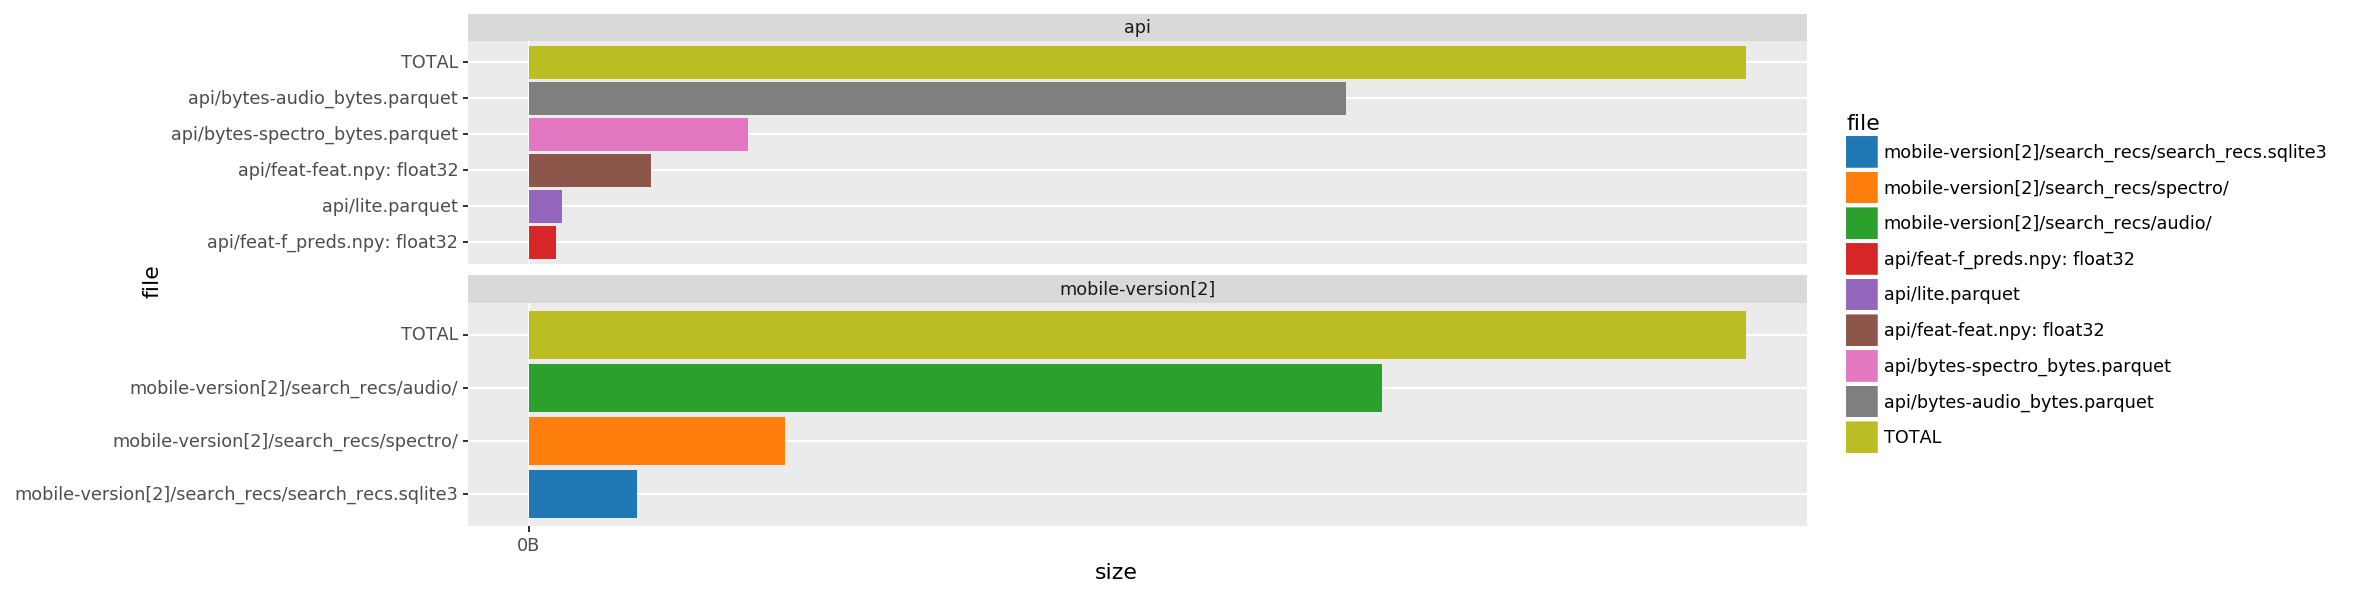

<ggplot: (-9223372036542058948)>

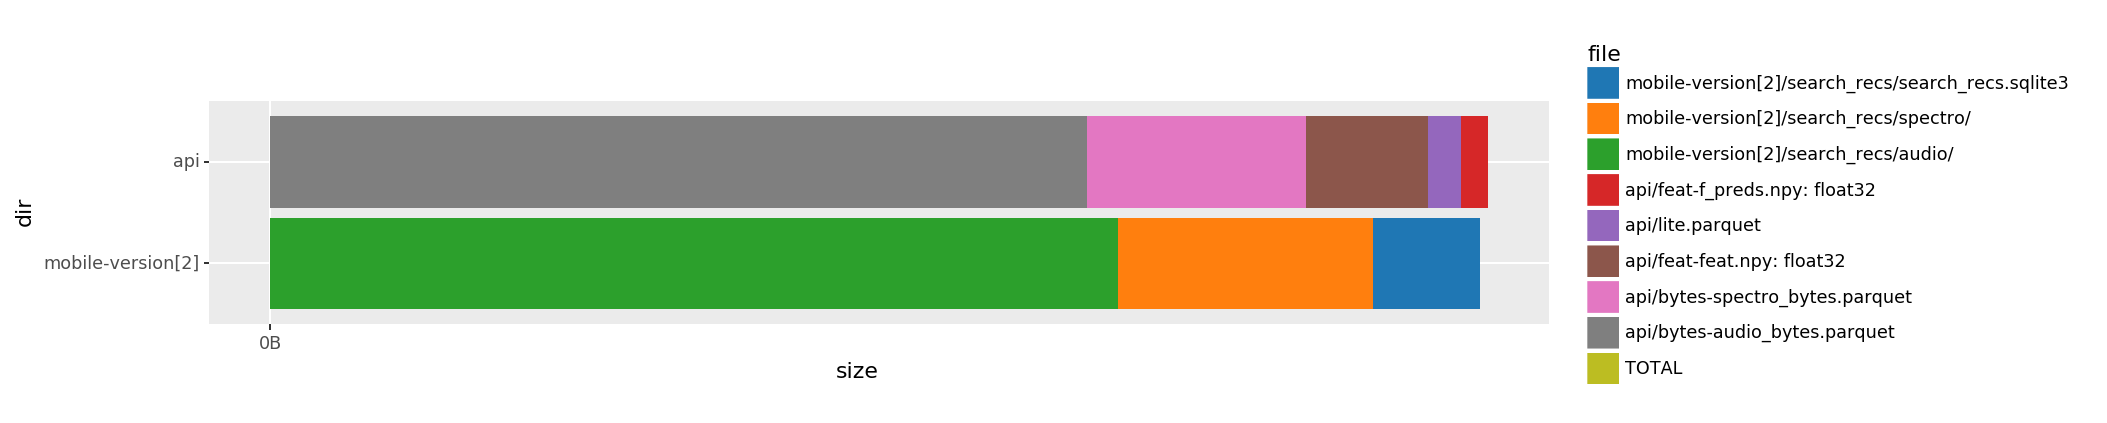

<ggplot: (330663414)>

,size,type,0
xc_id,36,int,416421
feat,104,ndarray,[ 2.872e-02 -2.151e-02 -3.703e-01 -2.697e-03 -1.268e-02 8.456e-02 2.277e-01 1.489e-01 -1.414e-01 9.737e-02 1.356e-01 -2.400e-01 5.771e-02 1.620e-02 1.130e-01 4.74...
f_preds,104,ndarray,[4.138e-04 1.147e-03 4.068e-07 2.627e-08 9.826e-03 9.456e-07 2.984e-07 4.845e-04 8.321e-08 3.356e-04 2.281e-04 2.211e-07 9.809e-05 9.184e-04 2.278e-05 3.288e-03 1.257e-04 ...
background,80,list,"['Killdeer (Charadrius vociferus)', 'Common Gallinule (Gallinula galeata)']"
background_species,80,list,"['KILL', 'COGA']"


In [ ]:
with ExitStack() as stack:
    # stack.enter_context(cache_control(refresh=True))  # XXX Debug
    log_levels({
        'payloads': 'INFO',
        # 'payloads': 'DEBUG',
    })
    kwargss = [
        # dict(cache_type='hybrid', refresh=True),  # Simulate cache miss [XXX Debug]
        dict(cache_type='hybrid'),                  # Allow cache hit
    ]
    search_recss = []
    for i, kwargs in enumerate(kwargss):
        if i > 0: print()
        print(f'search_recs(**{kwargs})')
        get_search_recs.cache_clear()
        search_recs = get_search_recs(**kwargs,
            write_mobile_payload=True,
            plot_sizes=True,
        )
        search_recss.append(search_recs)
        display(search_recs
            [['xc_id', 'feat', 'f_preds', 'background', 'background_species']]
            [2:3].reset_index(drop=True).T
            .pipe(df_assign_first,
                size=lambda df: df.T.memory_usage(deep=True),
                type=lambda df: df[0].map(lambda x: type(x).__name__),
            )
        )

In [ ]:
# TODO Turn this into unit tests
#   - Should roundtrip, should preserve category dtypes, should fail if index present
assert len(search_recss) == 2, "Test requires both 'cache hit' + 'cache miss' to be uncommented (above)"
[a, b] = search_recss
pd.testing.assert_frame_equal(a, b, check_column_type=True,
    check_index_type=False,  # Allow Int64Index vs. RangeIndex
)

[skip]